In [1]:
!pip install xarray

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
import xarray as xr
import zarr
import seaborn as sns
import pandas as pd
import sys

In [2]:
print(Path.cwd())
dataset=xr.open_zarr('/Users/kevinha/Downloads/seasfirecube.zarr')

/Users/kevinha/VYPREarth


/var/folders/fd/c30byq417d3dh1ystdk504100000gp/T/ipykernel_9484/1535083100.py:2: RuntimeWarning: Failed to open Zarr store with consolidated metadata, but successfully read with non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  dataset=xr.open_zarr('/Users/kevinha/Downloads/seasfirecube.zarr')


In [3]:
dataset

<xarray.Dataset>
Dimensions:             (time: 966, latitude: 720, longitude: 1440)
Coordinates:
  * latitude            (latitude) float64 89.88 89.62 89.38 ... -89.62 -89.88
  * longitude           (longitude) float64 -179.9 -179.6 -179.4 ... 179.6 179.9
  * time                (time) datetime64[ns] 2001-01-01T12:00:00 ... 2021-12...
Data variables: (12/35)
    BAs_GWIS            (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    BurntArea           (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    FCCI_BA             (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    FCD_emissions       (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    FRP_emissions       (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    LST_Day_CMG         (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    ...                  ...
    t2mmax              (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    t2mmin              (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    tp                  (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    vpd_cf              (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    wp                  (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>
    ws10                (time, latitude, longitude) float32 dask.array<chunksize=(966, 180, 360), meta=np.ndarray>

In [4]:
def select_variable_data(dataset, variable_name):
    return dataset[variable_name]
def select_spatio_temporal_data(dataset, initial_timestep, timesteps, latitude, longitude):
    if(latitude == -1 and longitude == -1):
        return dataset.isel(time=slice(initial_timestep, initial_timestep+timesteps))
    return dataset.isel(time=slice(initial_timestep, initial_timestep+timesteps), latitude=latitude, longitude=longitude)

In [5]:
def prepTime(time,latitude, longitude):
    features=['BAs_GWIS', 'FCCI_BA','ws10','Lai','swvl1','mslp','rH_cf', 'FCD_emissions', 'FRP_emissions', 'ssr','NDVI','nina34_anom','ssr']
    BurntArea=select_spatio_temporal_data(select_variable_data(dataset, 'BurntArea'), time, 1, latitude,longitude)
    df=BurntArea.to_dataframe()
    for str in features:
            dfTemp= select_spatio_temporal_data(select_variable_data(dataset, str), time, 1, latitude,longitude).to_dataframe()
            df[str]=dfTemp[str]
    return df
            

In [6]:
def prepRegion(latitude, longitude):
    result=prepTime(0,latitude, longitude)
    for time in range(9,15,6):
        result=pd.concat([result, prepTime(time, latitude, longitude)])
        print(time)
    return result
    

In [7]:
def regionBounds(latStart, latEnd, longStart, longEnd):
    result=prepRegion(latStart, longStart)
    for lat in range(latStart+1, latEnd):
        for long in range(longStart+1, longEnd):
            print(lat)
            print(long)
            result=pd.concat([result, prepRegion(lat, long)])
    return result

In [8]:
def analyze(df,meanFeature, drops):
    for drop in drops:
        df=df.drop(drop, axis=1)
    print(df.info())
    print(df.describe())
    print("mean: ", end=" ")
    print(df.loc[:,meanFeature].mean())
    corr2=df.corr()
    cmap=sns.diverging_palette(230,20,as_cmap=True)
    print(sns.heatmap(corr2,cmap=cmap))
    print("na values")
    print(df.isna().sum())
    return df
    

In [9]:
def uni(data,variable):
    sns.set(style="darkgrid")
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    sns.boxplot(data=data,x=variable, ax=ax_box)
    sns.histplot(data=data, x=variable, ax=ax_hist,kde=True)
    ax_box.set(xlabel='')
    plt.show()
    sns.countplot(x=variable,data=data)

In [30]:
#regionBounds(lat_start,lat_end, long_start, long_end), got dataframe
df= pd.read_csv('/Users/kevinha/VYPREarth/dataExploration/datasets/allVariablesOneLocation.csv')
Path.home()

PosixPath('/Users/kevinha')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86168 entries, 0 to 86167
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   BurntArea    86168 non-null  float64
 1   DCM          86056 non-null  float64
 2   LST          85054 non-null  float64
 3   WIND         86168 non-null  float64
 4   PRECIP       86168 non-null  float64
 5   SSR          86168 non-null  float64
 6   LST_Day_CMG  85054 non-null  float64
 7   Lai          86162 non-null  float64
 8   censo        86168 non-null  float64
 9   ea           86168 non-null  float64
 10  epo          86168 non-null  float64
 11  gmsst        86168 non-null  float64
 12  mslp         86168 non-null  float64
 13  nao          86168 non-null  float64
 14  nina34_anom  86168 non-null  float64
 15  pdo          86168 non-null  float64
 16  pna          86168 non-null  float64
 17  rH_cf        86168 non-null  float64
 18  skt          86168 non-null  float64
 19  soi 

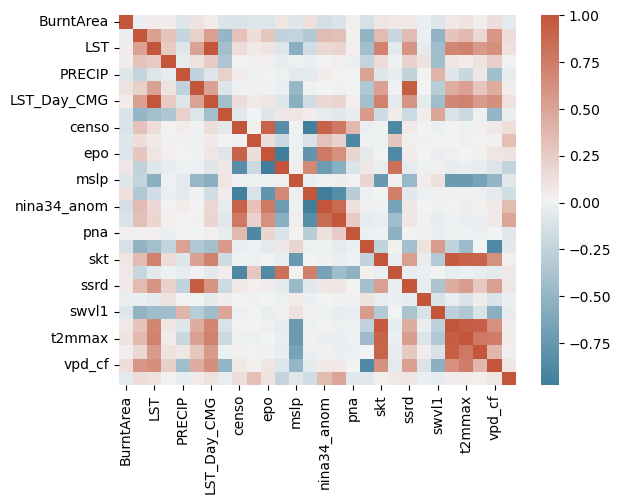

In [31]:
df=analyze(df,'BurntArea',['fcd_emissions','FRP_emissions','fwi','mean_fwi','population_density','latitude','longitude','Unnamed: 0'])

In [36]:
df=df.dropna()

In [37]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
X=df.drop('BurntArea', axis=1)
y=df['BurntArea']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)
dTree=DecisionTreeRegressor()
dTree.fit(X_train,y_train)
dTree.score(X_test,y_test)


-0.44904638104786754

In [38]:
from sklearn.ensemble import RandomForestRegressor
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)
dTree=RandomForestRegressor(n_estimators=10)
dTree.fit(X_train,y_train)
dTree.score(X_test,y_test)

0.25715320690235455

In [39]:
from sklearn.ensemble import GradientBoostingRegressor
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)
dTree=GradientBoostingRegressor(n_estimators=12)
dTree.fit(X_train,y_train)
dTree.score(X_test,y_test)

0.08247681793896178